# An Inferential Analysis of Factors Influencing Airbnb Prices in Athens
## STAT 301: Statistical Modelling for Data Science

### Group 33: 
- Lexie Wen: 34889204
- Marylyn Yuwono: 45608643
- Xinghao Huang: 81848509
- Zhenyu Zhong: 50922293

### Date: December 6, 2025
---

## Introduction

- Relevant background: Airbnb has become one of the most widely used accommodation platforms, offering travellers access to a broad range of listings that differ in location, quality, room type, and host characteristics. Understanding what factors are associated with Airbnb pricing is valuable for both travellers who want to find fair prices and for hosts who aim to competitively price their listings. 

- The primary goal of this question is inference. We aim to quantify associations from observational data, not estimate causal effects (which is not possible with our non-experimental dataset).

- ***Research Question:*** How are listing characteristics (e.g. room type, host is superhost or not), location features (e.g.distance to metro station, distance to city center) and booking timing (weekday or weekend) associated with the full price of airbnb accommodation for two people and two nights in Athens (response)?

- Our analysis aligns with the existing literature on Airbnb price determinants, although we restrict attention to Athens and use only tools taught in class (multiple linear regression, variable selection through VIF, diagnostics, and model comparison).


---

## Methods and Results

### a) Data

Reproducible Code

In [31]:
# Load Athens Airbnb datasets from GitHub URLs of our repository
athens_weekdays <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekdays.csv", header = TRUE)
athens_weekends <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekends.csv", header = TRUE)

Citation of the Original Source

- Gyódi, K., & Nawaro, Ł. (2021, March 25). Determinants of Airbnb prices in European cities: A Spatial Econometrics Approach (supplementary material). Zenodo. https://zenodo.org/records/4446043#.Y9Y9ENJBwUE 

Data Collection Information: 
- The datasets were originally obtained from Gyódi and Nawaro (2021), Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach (supplementary material), published on Zenodo.

- The data were collected from Airbnb listings across multiple European cities, focusing on listing attributes, host information, and spatial factors affecting pricing.

- The data were **observational** since the variables were collected from Airbnb listings without any treatment assignment or random process.

- This dataset offers a detailed overview of Airbnb prices in Athens, including information on room type, cleanliness and satisfaction ratings, number of bedrooms, distance from the city centre, and other attributes that help explain price differences between weekday and weekend stays.

Variable Summary

| Variable | Type | Description |
|-----------|-----------|-----------|
| realSum | Quantitative data | the total prices of the listing |
| room_type | Categorical/nominal data | different room types, including *private*, *shared*, *entire home*, *apt*. |
| room_shared | Categorical/binary data| whether a room is shared |
| room_private | Categorical/binary data | whether a room is private |
| person_capacity | Quantitative data | number of people a room can accommodate |
| host_is_superhost | Categorical/binary data | whether a host is a superhost |
| multi | Categorical/binary data | whether the listing is for multiple rooms |
| biz| Categorical/binary data | whether an observation is associated with a business |
| cleanliness_rating | Quantitative data | rating of cleanliness |
| guest_satisfaction_overall | Quantitative data | overall rating from guests comparing all listings offered by the host |
| bedrooms | Quantitative data | number of bedrooms |
| dist | Quantitative data | distance from city center |
| metro_dist | Quantitative data | distance from the nearest metro station |
| attr_index | Quantitative data | attr index |
| attr_index_norm | Quantitative data | normalized attr index |
| rest_index | Quantitative data | rest index |
| rest_index_norm | Quantitative data | normalized rest index |
| lng | Quantitative data | longitude coordiates for location identification |
| lat | Quantitative data | latitude coordiates for location identification |


Preselection of Variables

- ***room_shared***, ***room_private***, and ***multi*** have redundant information because we can also acquire the same and even more complete information from ***room_type*** and ***bedrooms***.

- ***lng*** and ***lat*** will be dropped because they only provide raw spatial coordinates, and information regarding distance can be acquired from ***dist*** and ***metro_dist***

- ***attr_index***, ***attr_index_norm***, ***rest_index***, and ***rest_index_norm*** will also be dropped because their definitions and interpretations are unclear from the dataset documentation, and they seem like post-analysis results.

### b) Exploratory Data Analysis

In [32]:
# Load necessary libraries
install.packages("tidyverse")
install.packages("ggplot2")
install.packages("patchwork")

library(tidyverse)
library(ggplot2)
library(patchwork)


The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages


Data Wrangling

In [33]:
# Add an indicator column 'day_type' to each dataset
athens_weekdays <- athens_weekdays %>% mutate(day_type = as.factor("Weekdays"))
athens_weekends <- athens_weekends %>% mutate(day_type = as.factor("Weekends"))

# Combine the two datasets into one
athens <- rbind(athens_weekdays, athens_weekends)

Potential Problem(s)

In [34]:
summary(athens$realSum)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   42.88    98.66   127.72   151.74   171.54 18545.45 

Note that there are potentially extreme outliers in ***realSum***. They will make it harder to see the pattern of the majority of individual observations. Therefore, we are going to filter them out to have a better view for the visualization. 

The values within the whiskers, [Q1 - 1.5IQR, Q3 + 1.5IQR], are included, which are the non-outlier observations among the original values of ***realSum***.

In [35]:
# filter the data
realSum_within_range <- athens %>%
    group_by(room_type, day_type) %>%
    filter( (realSum >= quantile(realSum,0.25)-1.5*IQR(realSum)) & (realSum <= quantile(realSum,0.75)+1.5*IQR(realSum)) ) %>%
    ungroup() %>%
    select(realSum, day_type, room_type, dist) # these 4 variables will be used for the EDA visualization(s)


Visualization 1

In [36]:
# boxplot with original realSum values
box_price_by_room_original <- athens %>%
    ggplot(aes(x = day_type, y = realSum, fill = day_type)) +
    geom_boxplot(fatten = 4) + # adjust the width of the median bar
    geom_jitter(color="gray", size=0.4, alpha=0.6) + # adding individual observations
    facet_grid(~room_type) + # facet by room_type
    ggtitle("Unfiltered Airbnb Prices Distribution per Room/Day Type") +
    labs(x = "Day Types", y = "Unfiltered Airbnb Price in Athens", fill = "Day Type")


# boxplot with filtered realSum values
box_price_by_room_filtered <- realSum_within_range %>%
    ggplot(aes(x = day_type, y = realSum, fill = day_type)) +
    geom_boxplot(fatten = 4) + # adjust the width of the median bar
    geom_jitter(color="gray", size=0.4, alpha=0.6) + # adding individual observations
    facet_grid(~room_type) + # facet by room_type
    ggtitle("Filtered Airbnb Prices Distribution per Room/Day Type") +
    labs(x = "Day Types", y = "Filtered Airbnb Price in Athens", fill = "Day Type")

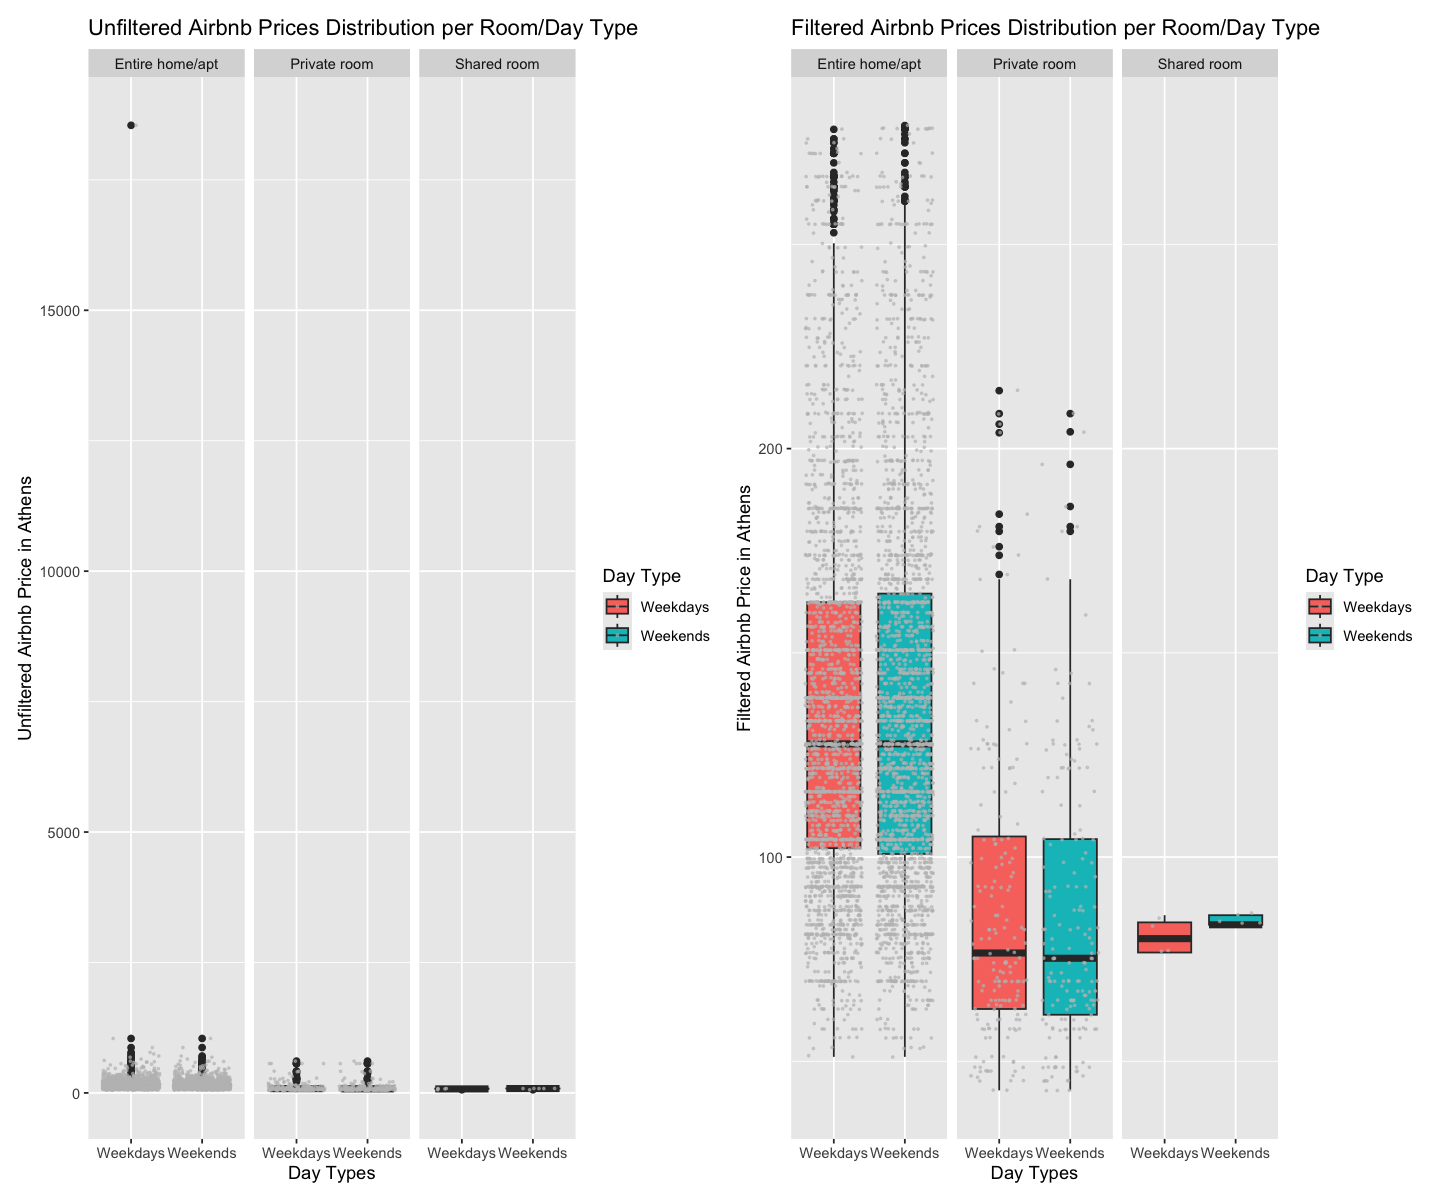

In [37]:
# Adjust plot size for better visibility
options(repr.plot.width = 12, repr.plot.height = 10)

# Display the two boxplots side by side for comparison
box_price_by_room_original + box_price_by_room_filtered

Visualization 2

`geom_smooth()` using formula = 'y ~ x'


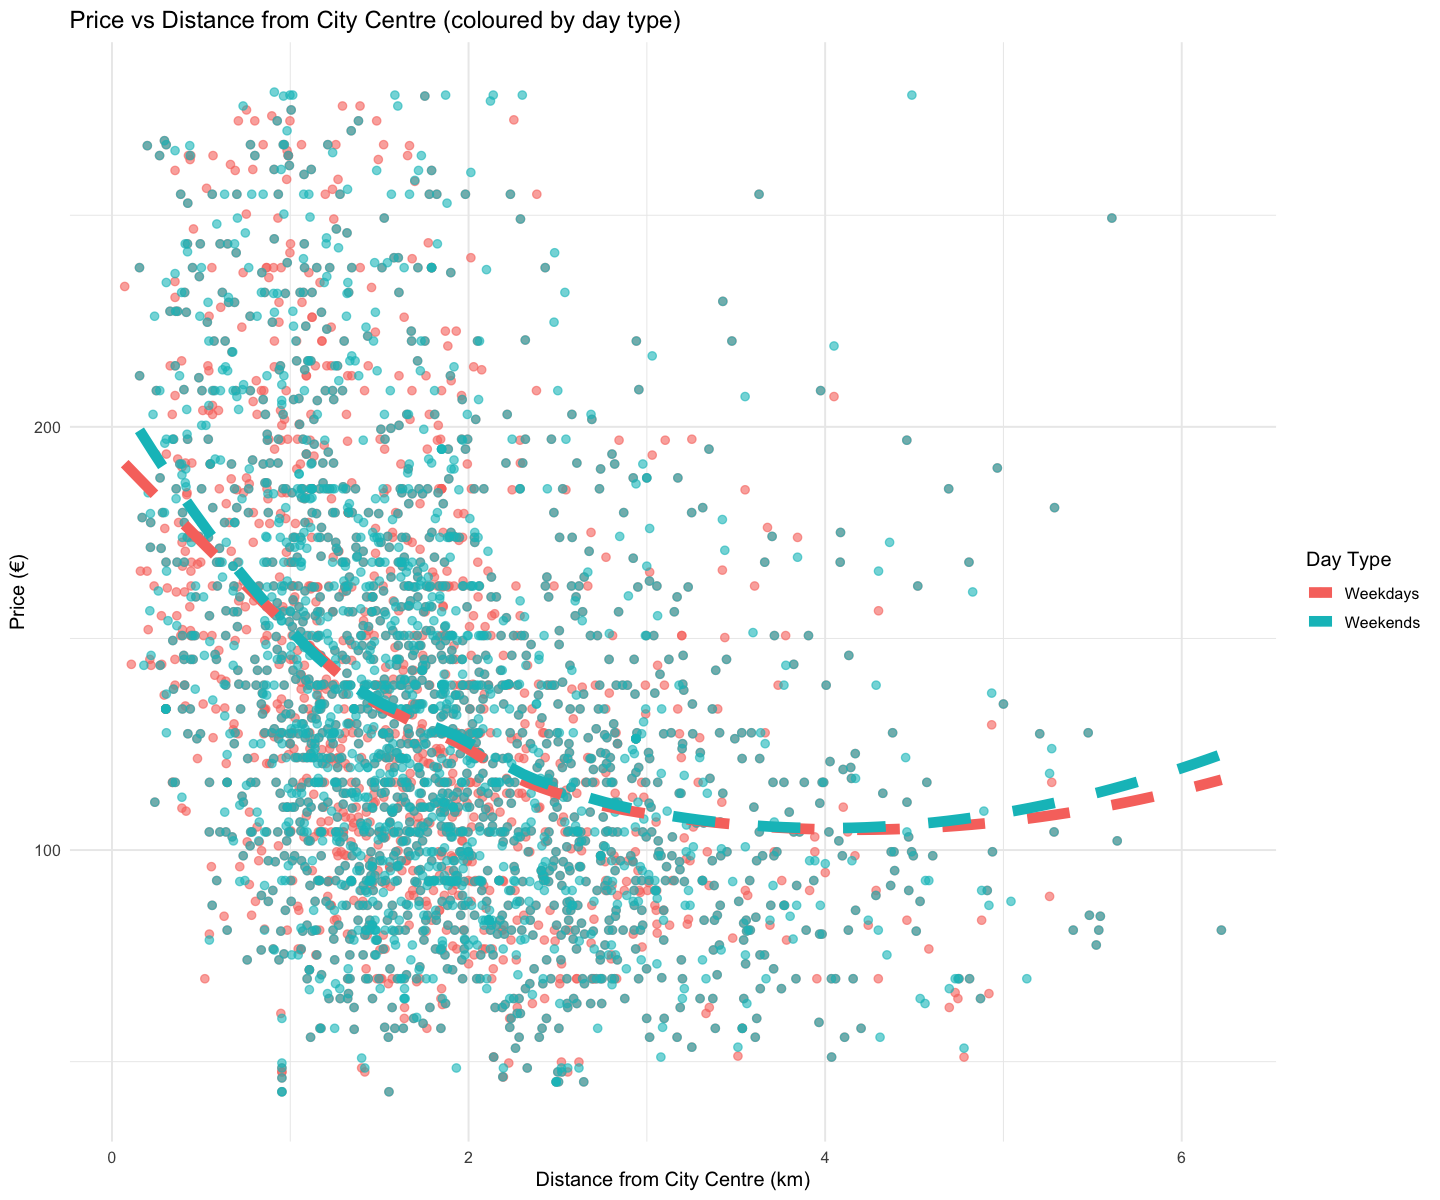

In [38]:
# scatterplot of price vs distance (using filtered realSum values)
scatter_distance_by_day <- ggplot(realSum_within_range, aes(x = dist, y = realSum, color = day_type)) +
  geom_point(alpha = 0.6, size = 2) +      # plot individual observations
  geom_smooth(aes(group = day_type), method = "loess", se = FALSE, linetype = "dashed", linewidth = 3) +     # add smoothed trend lines
  labs(
    title = "Price vs Distance from City Centre (coloured by day type)",
    x = "Distance from City Centre (km)",
    y = "Price (€)",
    color = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "right")

scatter_distance_by_day

### c) Methods: Plan

- **Model Selection:** 

    - A multiple linear regression model will be suitable to address the proposed question.

- **Justifications:**

    - The response (Airbnb price) is continuous, so MLR is the correct modelling family. 

    - It allows us to select multiple covariates and model the expected Airbnb price.

    - And, since the response will be the Airbnb price, Logistic regression that models the log-odds or Poisson regression that models the log-mean count are not appropriate to model the price.

- **Model Assessment Plan:**

    - **Multicollinearity Check:** We will compute VIF/GVIF for all predictors and remove those with unusually high values to reduce multicollinearity.

    - **Model Comparison:** We will fit a full model (after VIF screening) and some reduced models based on EDA, and use a nested-model F-test to evaluate whether the full model provides significantly better explanatory power.

    - **Diagnostic Checks:** We will use diagnostic plots to assess linearity, normality of residuals, constant variance, and influential observations.
    
    - **Transformation (if needed):** If diagnostics reveal major assumption violations, we will apply a log transformation to the response, refit the model, and reevaluate diagnostics.
    
    - **Inference and Interpretation:** We will interpret the coefficients of the final model in terms of the associations between predictors and the response, and perform hypothesis tests to assess whether these relationships are statistically significant.

### d) Code and Results (SIP)



In [39]:
# load necessary libraries for modeling
install.packages("car")
install.packages("gridExtra")
install.packages("readr")
install.packages("dplyr")
install.packages("rsample")
install.packages("leaps")
install.packages("tidymodels")
install.packages("workflows")

library(car)
library(gridExtra)
library(readr)
library(dplyr)
library(rsample)
library(leaps)
library(tidymodels)
library(workflows)


The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpugMVvA/downloaded_packages


Split the Dataset

In [40]:
set.seed(1234)

# Split the data into training (70%) and testing (30%) sets
athens_split <- 
    athens  %>%
    initial_split(prop = 0.7)

# Create training and testing datasets
athens_selection <- training(athens_split)
athens_inference <- testing(athens_split)


VIF Checking

In [47]:
# The full model contains all predictors (except room_shared and room_private since they are contained in romm_type. Otherwise it will cause the aliasing problem) in the dataset
model_for_vif <- lm(realSum ~ . - room_shared - room_private, data = athens_selection)

# Calculate VIF for each predictor in the full model
vif_values <- vif(model_for_vif)

# Identify predictors with VIF greater than 5 (based on the rule of thumb)
adj_gvif <- vif_values[, "GVIF^(1/(2*Df))"] 
high_gvif <- adj_gvif[adj_gvif > 5]
high_gvif


attr_index attr_index_norm 
       3925.576        3925.872

- **attr_index** and **attr_index_norm** have unusal exteme values of VIF and GVIF, indicating they are highly correlated. So, they will be dropped to reduce multicollinearity

Nested Model Comparison

In [24]:
# This model contains all the predictors selected after VIF check
model_full <- lm(realSum~ . - room_shared - room_private - attr_index - attr_index_norm, data = athens_selection)

# This model contains the predictors that we believe are relevant based on EDA and our research question
model_reduced_1 <- lm(realSum ~ day_type + room_type + guest_satisfaction_overall + dist, data = athens_selection)

# This is another reduced model, which contains
model_reduced_2 <- lm(realSum~ . - room_shared - room_private - attr_index - attr_index_norm - rest_index - rest_index_norm - lat - lng, data = athens_selection)

In [48]:
# Perform ANOVA to compare the reduced model 1 with the full model
anova_result_1 <- anova(model_reduced_1, model_full)

# Extract the p-value from the ANOVA result
anova_p <- anova_result_1$`Pr(>F)`[2]

anova_p


[1] 4.786984e-212

- The F-test shows a highly significant difference (p < 0.001), indicating that the full model provides a significantly better fit than the first reduced model. Therefore, we retain the full model.

In [49]:
# Perform ANOVA to compare the reduced model 2 with the full model
anova_result_2 <- anova(model_reduced_2, model_full)

# Extract the p-value from the ANOVA result
anova_p <- anova_result_2$`Pr(>F)`[2]

anova_p


[1] 4.994214e-44

- Here the result is similar, indicating that the full model also provides a significantly better fit than the second reduced model. Therefore, we retain the full model.

Model Diagonsis

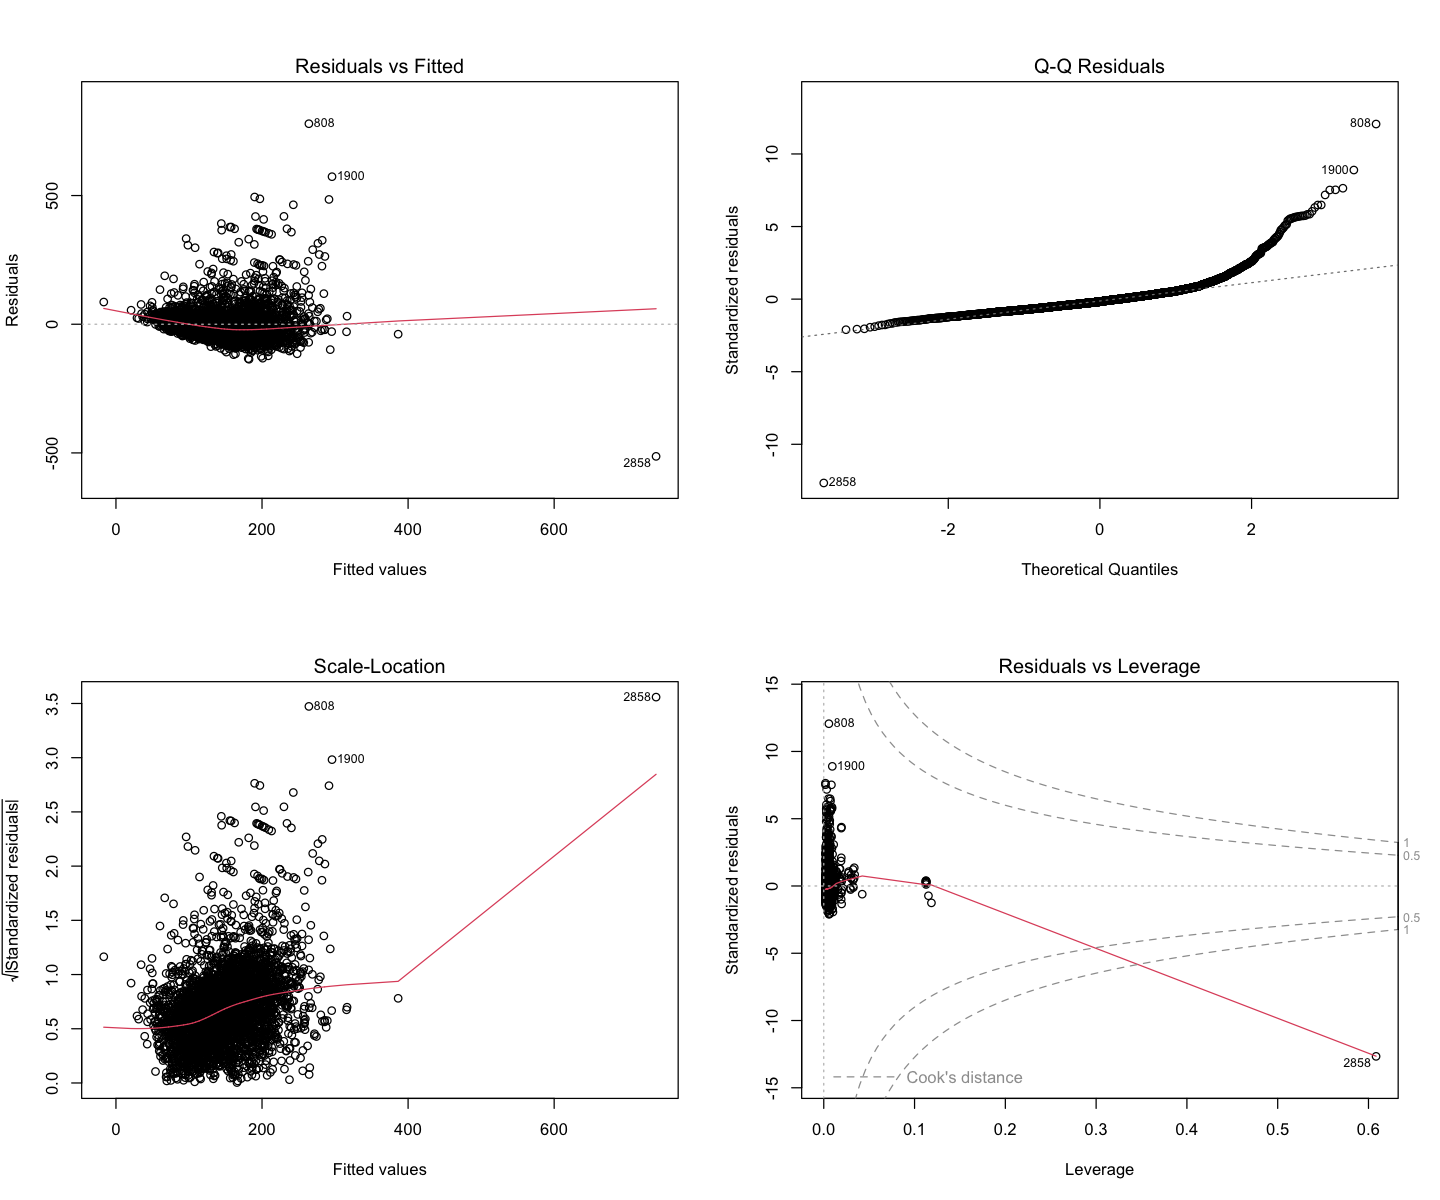

In [27]:
# Diagnostic plots for the full model
par(mfrow = c(2, 2))
plot(model_full)

- Issues:

    - **Heteroscedasticity:** The Residuals vs Fitted plot displays a clear funnel shape, where the spread of residuals increases as fitted values ncrease. This indicates non-constant variance, violating the homoscedasticity assumption of the linear regression model.

    - **Non-normal residuals:** The Q–Q plot shows noticeable deviation in the right tail, where several points fall well above the reference line. This suggests that the error terms are not normally distributed and that the data exhibit right-skewness.

    - **Outliers and influential observations:** Several points (e.g., IDs 8086, 1900, and 2858) appear with unusually large residuals across multiple plots. These observations act as outliers and may exert disproportionate influence on the fitted model.

- Adjustments:

    - To address the above issues, we will apply a logarithmic transformation to the response variable (realSum). Modeling log(realSum) typically stabilizes variance, reduces right-skewness, and mitigates the influence of extreme price values, leading to a model that better satisfies linear regression assumptions.

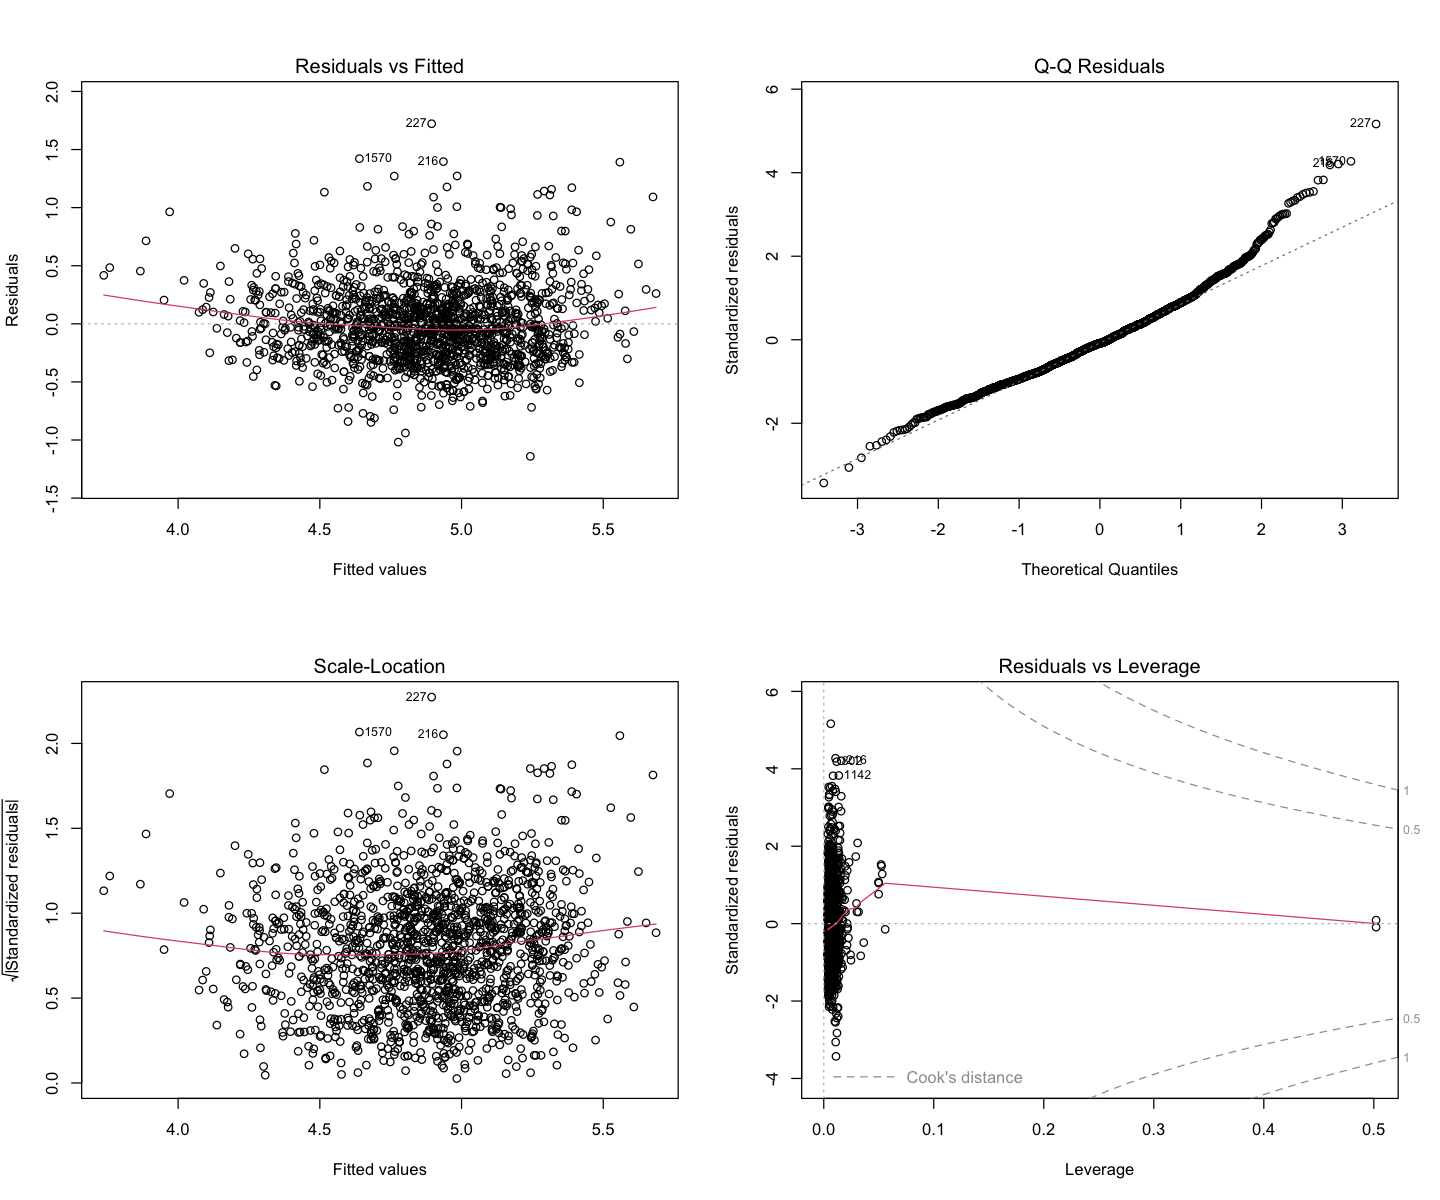

In [28]:
# Apply log transformation to the response variable to address the above issues
model_full_log <- lm(log(realSum)~ . - room_shared - room_private - attr_index - attr_index_norm - rest_index - rest_index_norm - guest_satisfaction_overall - lng - lat, data = athens_inference)

# Diagnostic plots for the transformed full model
par(mfrow = c(2, 2))
plot(model_full_log)

- After applying a logarithmic transformation to the response, diagnostic plots show substantial improvement in model assumptions. Residuals exhibit homoscedasticity, approximate normality, and no severe influential points. Therefore, the transformed model is considered appropriate for inference.

Intepretations

In [50]:
# Perform tidy to get the model summary with exponentiated coefficients and confidence intervals
result <- tidy(model_full_log, exponentiate = TRUE, conf.int = TRUE)

result

# Adjusted R-squared values for the models
summary(model_reduced_1)$adj.r.squared # adjusted R-squared for reduced model 1
summary(model_reduced_2)$adj.r.squared # adjusted R-squared for reduced model 2
summary(model_full)$adj.r.squared # adjusted R-squared for full model (without log transformation)
summary(model_full_log)$adj.r.squared # adjusted R-squared for full model (with log transformation)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),62.4132588,1.004045e-01,41.171222,5.961689e-252,51.2562066,75.9988913
X,1.0000478,1.113146e-05,4.291180,1.885763e-05,1.0000259,1.0000696
room_typePrivate room,0.7233608,3.284938e-02,-9.858546,2.748470e-22,0.6782222,0.7715036
room_typeShared room,0.7281223,2.375232e-01,-1.335812,1.818043e-01,0.4569496,1.1602199
person_capacity,1.0858383,9.124212e-03,9.025690,5.082628e-19,1.0665780,1.1054464
host_is_superhostTrue,1.0447546,1.775808e-02,2.465470,1.378959e-02,1.0089901,1.0817867
multi,1.0504135,2.175141e-02,2.261181,2.388429e-02,1.0065403,1.0961990
biz,1.1937901,2.025056e-02,8.747077,5.527277e-18,1.1473010,1.2421629
cleanliness_rating,1.0583804,9.716625e-03,5.839456,6.352124e-09,1.0383998,1.0787454


[1] 0.1311204

[1] 0.3025294

[1] 0.3402917

[1] 0.4398617

Interpretations of The Results

- TO BE CONTINUED

## Discussion (SIP)

- *(REPLACE IT) Implications of our findings*
- *(REPLACE IT) Discuss whether your results were what we expected to find*
- *(REPLACE IT) Discuss how your model could be improved*
- *(REPLACE IT) Discuss future questions/research this study could lead to*

---
## References (SIP)